In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import jax.random as jr
import tensorflow_probability as tfp
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd

from sbijax import plot_posterior, plot_trace, plot_rank, plot_rhat_and_ress
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import matplotlib as mpl
mpl.rcParams.update({"text.usetex": False,
                     })#mpl.rcParamsDefault)

mpl.rcParams.update(mpl.rcParamsDefault)

gpu


2025-01-05 21:25:56.205062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 21:25:56.205098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 21:25:56.206246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 21:25:59.182945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tfp.__version__

'0.24.0'

In [3]:
jnp.ones((3,))

2025-01-05 21:26:21.501212: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([1., 1., 1.], dtype=float32)

In [4]:
pwd

'/home/makinen/repositories/des-hybrid'

In [5]:
cd wl-sbi/automate_run

/home/makinen/repositories/des-hybrid/wl-sbi/automate_run


/home/makinen/venvs/epe/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# des tfrecords loader code

In [6]:
foos = ["1_1", "3_4"]

if "_" in foos[0]:
    print('yeet')

yeet


In [7]:
import glob
import os

import tensorflow as tf
import tensorflow_datasets as tfds


base_path = "/data103/makinen/des_sims/Gower_street_SBI_tfrecords/"
patch = "A"
use_noise_realisations =['0','1','2','3','10', '11']#,'11','12','13','14','15']



def gaussian_noise_augmentation(x, y, cls):
    x += tf.random.normal(
                        shape = [512, 512,8],
                        mean = 0,
                        stddev = 1e-7,
                        dtype = tf.float32
                        ) #Mask option?
    return x,y, cls

def gaussian_noise_augmentation(x, y, cls):
    x += tf.random.normal(
                        shape = [512, 512,8],
                        mean = 0,
                        stddev = 1e-5,
                        dtype = tf.float32
                        ) #Mask option?

    # data is now a dictionary
    
    return {"y": {"kappa": x, "cls": cls}, "theta": y}


def ret_scaled_param(data,param):
    s = 0.6
    if param == 'AIA':
        hi = 3
        lo = -3

    if param == "s8":
        hi = 1.32
        lo = 0.4

    if param == 'om':
        hi = 0.5
        lo = 0.13

    if param == "h":
        hi = 0.6
        lo = 0.8

    if param == 'w':
        hi = -0.33
        lo = -1.8
    if param == "ns":
        hi = 0.99
        lo = 0.94
    if param == 'ob':
        hi = 0.061
        lo = 0.037


    return (data[param] -lo)*s/(hi - lo) + (1 - s)*0.5

def param_proc(data, scale_params=True):
    Y = []
    for p in sel_params:
        # scale params if so desired
        if scale_params:
            if p=="S8":
                Y.append(data["s8"]*tf.math.sqrt(data["om"]/0.3)-0.25)
            else:
                Y.append(ret_scaled_param(data, p))
                
        # else just return the param
        else:
            Y.append(data[p])
            
    Y = tf.convert_to_tensor( Y , dtype = tf.float32)
    return Y

def cls_proc(data):
    Cls = []
    for c in cl_modes:

        cls = tf.io.parse_tensor(data[c], out_type=tf.float32)
        cls = tf.cast(cls, tf.float32)
        
        Cls.append(cls)
    
    return Cls #tf.convert_to_tensor(Cls, dtype=tf.float32)

def return_train_test_lists(patch):
    files = glob.glob(base_path + "{}/".format(patch) +"shear_maps_*")
    print(base_path + "{}/".format(patch) +"shear_maps_*")
    print(len(files))
    train_file_list = []
    test_file_list = []
    lfi_file_list = []
    for file in files:
        noiserel = file.split("_rel")[0].split('noiserel')[-1]
        if noiserel in use_noise_realisations:
            if noiserel == '3':
                test_file_list.append(file)
            elif noiserel == '10':
                lfi_file_list.append(file)
            else:
                train_file_list.append(file)
    return train_file_list, test_file_list, lfi_file_list

def parse_serialized_file(cereal_yum, scale_params=True):

    features = {
            "kappa_patch":  tf.io.FixedLenFeature([], tf.string),
            #"CLS":  tf.io.FixedLenFeature([], tf.float32, default_value=0.0),

            # load the cls values
            "1_1": tf.io.FixedLenFeature([], tf.string),
            "1_2": tf.io.FixedLenFeature([], tf.string),
            "1_3": tf.io.FixedLenFeature([], tf.string),
            "1_4": tf.io.FixedLenFeature([], tf.string),
            "2_2": tf.io.FixedLenFeature([], tf.string),
            "2_3": tf.io.FixedLenFeature([], tf.string),
            "2_4": tf.io.FixedLenFeature([], tf.string),
            "3_3": tf.io.FixedLenFeature([], tf.string),
            "3_4": tf.io.FixedLenFeature([], tf.string),
            "4_4": tf.io.FixedLenFeature([], tf.string),

            # load parameters
            "s8": tf.io.FixedLenFeature([], tf.float32),
            "om": tf.io.FixedLenFeature([], tf.float32),
            "AIA": tf.io.FixedLenFeature([], tf.float32),
            "w": tf.io.FixedLenFeature([], tf.float32)
    }

    data = tf.io.parse_single_example(cereal_yum, features)

    #print("data cls", data["CLS"].shape)

    X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    X_DS = tf.cast(X_DS, tf.float32)
    X_DS = tf.reshape(X_DS, shape=(8,512,512))
    X_DS = tf.transpose(X_DS, perm = [1,2,0])

    #X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    #X_DS = tf.cast(X_DS, tf.float32)
    
    # process params and Cls
    Y = param_proc(data, scale_params=scale_params)
    CLS_DS = cls_proc(data)
    
    #Shapes?
    return X_DS,Y,CLS_DS




with tf.device("CPU"):
    sel_params = ["om","s8","w"]
    cl_modes = ["1_1","1_2","1_3","1_4","2_2","2_3","2_4","3_3","3_4", "4_4"]
    BATCH_SIZE = 64
    EPOCHS = 1000 # max epochs
    n_readers=1
    try:
        del train_dataset
        del test_dataset
        gc.collect()
    except:
        pass        

    SHUFFLE_BUFFER_SIZE = 100
    train_files, test_files, lfi_files = return_train_test_lists('{}'.format(patch))
    num_train_files = len(train_files)
    num_test_files = len(test_files)
    num_lfi_files = len(lfi_files)
    print("train files: ", num_train_files, "test files: ", num_test_files, "lfi files: ", num_lfi_files)

    train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
    train_dataset = train_dataset.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    # parse, output signature (kg, sn, cosmo, index)
    train_dataset = train_dataset.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    train_dataset = train_dataset.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


    # TEST DATASET
    test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
    test_dataset = test_dataset.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    # parse, output signature (kg, sn, cosmo, index)
    test_dataset = test_dataset.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    test_dataset = test_dataset.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)

    # test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    


    # SET DATASETS AS NUMPY ITERATORS
    train_dataset = train_dataset.repeat(EPOCHS).as_numpy_iterator()
    test_dataset = test_dataset.repeat(EPOCHS).as_numpy_iterator()

    train_dataset.num_samples = (num_train_files // BATCH_SIZE) * BATCH_SIZE
    train_dataset.num_batch_per_epoch = num_train_files // BATCH_SIZE
    
    test_dataset.num_samples = (num_test_files // BATCH_SIZE) * BATCH_SIZE
    test_dataset.num_batch_per_epoch = num_test_files // BATCH_SIZE
    
         
    lfi_dataset = tf.data.Dataset.from_tensor_slices(lfi_files)
    lfi_dataset = lfi_dataset.interleave(
        tf.data.TFRecordDataset,
        cycle_length=n_readers,
        block_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    # parse, output signature (kg, sn, cosmo, index)
    lfi_dataset = lfi_dataset.map(
        lambda serialized_example: parse_serialized_file(
            serialized_example,
            scale_params=False
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    
    lfi_dataset = lfi_dataset.map(lambda maps,vals,cls: gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)


    lfi_dataset = lfi_dataset.batch(BATCH_SIZE, drop_remainder=False)
    lfi_dataset = lfi_dataset.as_numpy_iterator()
    lfi_dataset.num_batch_per_epoch = num_lfi_files // BATCH_SIZE




/data103/makinen/des_sims/Gower_street_SBI_tfrecords/A/shear_maps_*
30880
train files:  12352 test files:  3088 lfi files:  3088


In [8]:
import jax

In [9]:
train_dataset.num_samples, train_dataset.num_batch_per_epoch, 

(12352, 193)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 512, 512, 8) [0.4825825 0.5745539 0.7461434] (64, 10, 2, 4, 28)


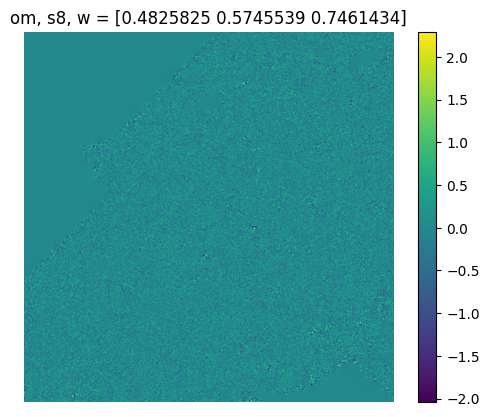

/tmp/ipykernel_18482/3926519482.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


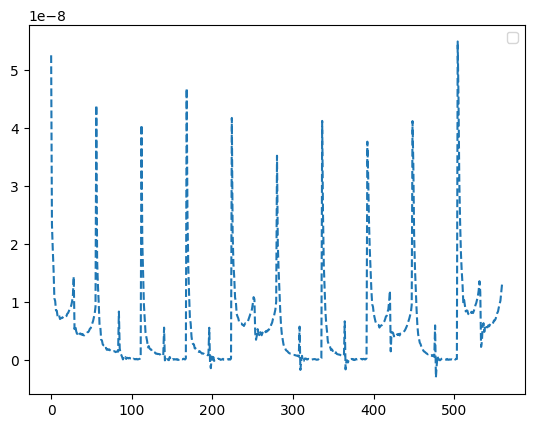

/tmp/ipykernel_18482/3926519482.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


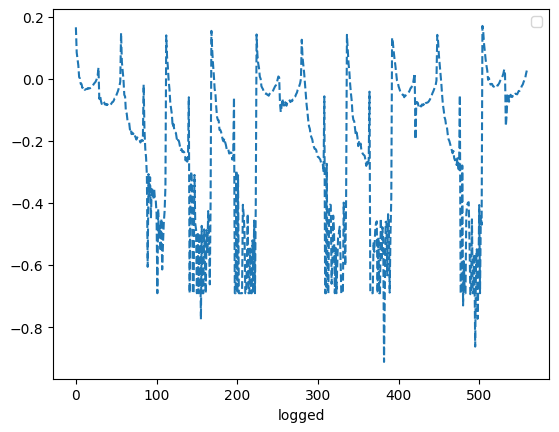

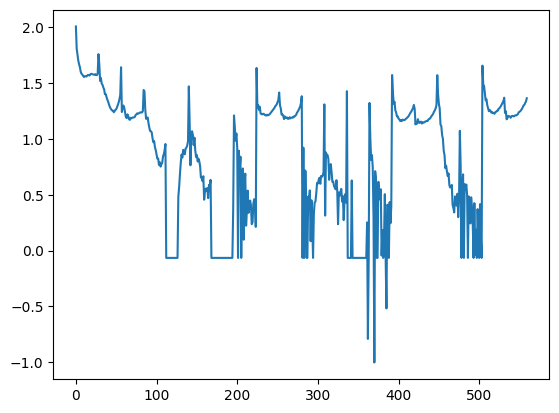

hists (80,)


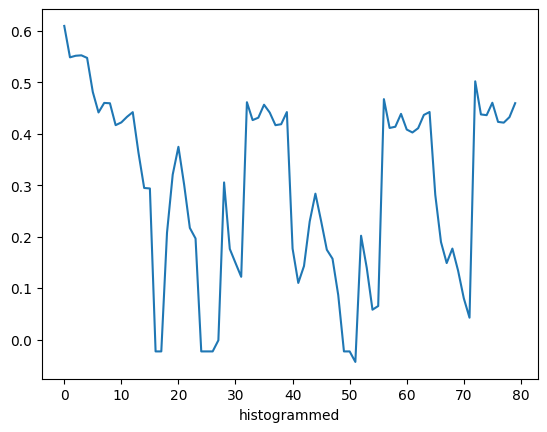

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 512, 512, 8) [0.49453247 0.48919064 0.7016754 ] (64, 10, 2, 4, 28)


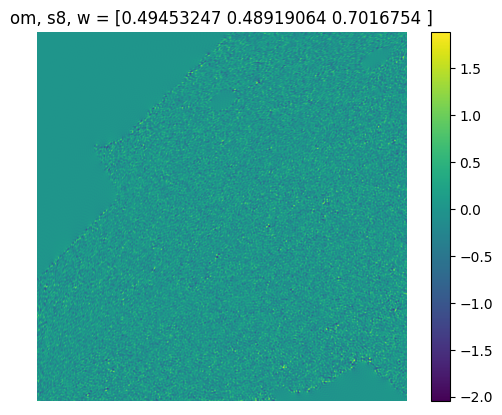

/tmp/ipykernel_18482/3926519482.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


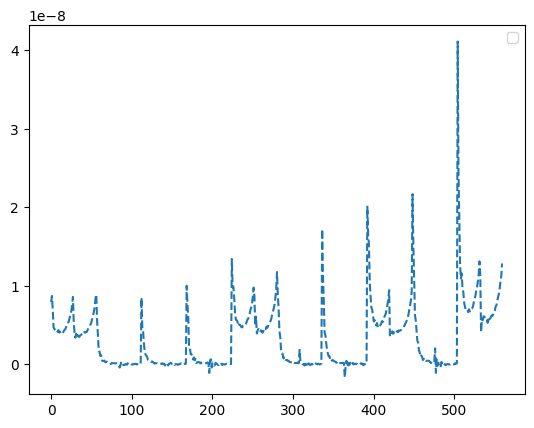

/tmp/ipykernel_18482/3926519482.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


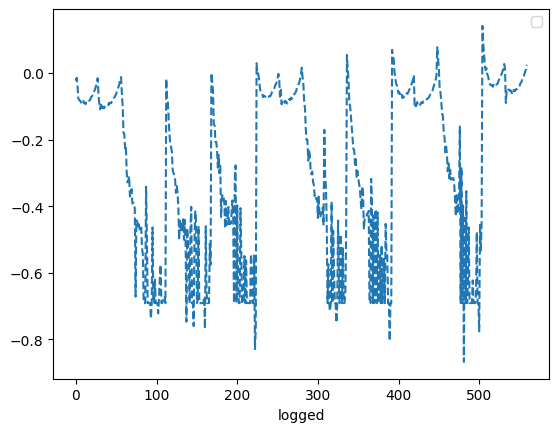

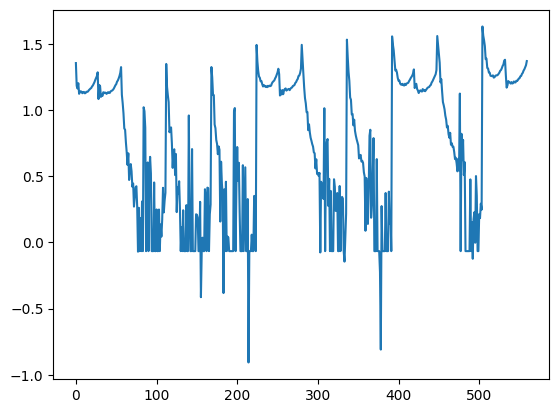

hists (80,)


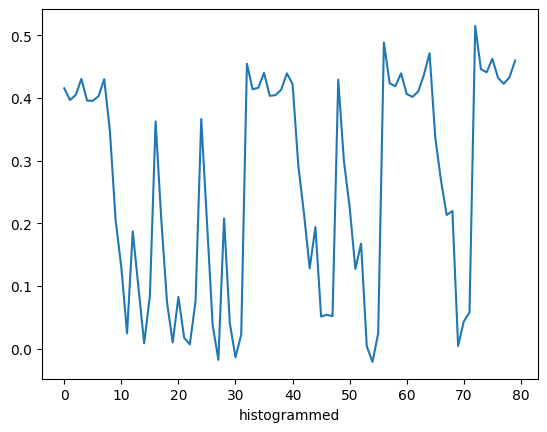

In [10]:
for i in range(2):
    data = next(iter(test_dataset))

    #data = next(train_dataset)

    x = data["y"]["kappa"]
    y = data["theta"]
    cls = data["y"]["cls"]
    #x, y = x.numpy(), y.numpy().tolist()
    print(type(x), type(cls))

    print(x.shape, y[0], cls.shape)

    #print(cls)
    
    
    #ax = plt.subplot(4, 4, i + 1)
    plt.imshow((x[0, :, :, 7]) * 10)
    plt.colorbar()
    plt.axis("off")
    #name = config.labels[y]
    plt.title("om, s8, w = " + str(y[0]), fontsize=12)
    plt.show()

    #plt.plot((cls[2, :, 0, 0, :]).reshape(-1,2,14,2).mean(-1).reshape(-1), label='dim 0') # (64, 10, 2, 4, 28) = (batch, tomo, E/B, patch ?, k-bin)
    #plt.plot((cls[2, :, 1, 0, :]).reshape(-1,2,14,2).mean(-1).reshape(-1), ls='--', label='dim 1')


    plt.plot((cls[2, :, 0, 0::3, :]).reshape(-1), ls='--') # (64, 10, 2, 4, 28) = (batch, tomo, mock/rand, E/B ?, k-bin)
    plt.legend()
    plt.show()


    cls = jnp.where(cls.reshape(-1) < 0, 1e-11, cls.reshape(-1)).reshape(cls.shape)

    plt.plot((jnp.log(cls[2, :, 0, 0::3, :] * 1e8) / 10.).reshape(-1), ls='--') # (64, 10, 2, 4, 28) = (batch, tomo, mock/rand, E/B ?, k-bin)
    plt.legend()
    plt.xlabel("logged")
    plt.show()

    # let's use this log-transformation
    plt.plot(np.concatenate(((jnp.log((cls)**2) + 50.) / 10.)[5, :, 0, 0::3, :], 0).reshape(-1)) # (64, 10, 2, 4, 28) = (batch, tomo, E/B, patch ?, k-bin)
    #plt.plot(np.concatenate(((jnp.log((cls)**2) + 50.) / 10.)[5, :, 1, 0::3, :], 0).reshape(-1))
    plt.show()
    
    #_histfn = lambda d: jnp.histogram((jnp.log(d**2) + 50.)/10., bins=5)[0]
    _histfn = lambda d: jnp.histogram(jnp.arange(28), weights=(jnp.log(d**2) + 50.)/200., bins=4)[0]
    _histfn = jax.vmap(_histfn)
    #hists = jax.vmap(_histfn)((((jnp.log((cls)**2) + 50.) / 10.)[5, :, 0, 0::3, :])).reshape(-1)
    hists = jax.vmap(_histfn)((cls)[5, :, 0, 0::3, :]).reshape(-1)
    print("hists", hists.shape)

    plt.plot(hists)
    plt.xlabel("histogrammed")

    #cls = jnp.where(cls.reshape(-1) < 0, 0, (jnp.log(cls.reshape(-1)))).reshape(cls.shape)

    #plt.plot((cls[2, :, 0, 0, :]).reshape(-1) , ls='--') # (64, 10, 2, 4, 28) = (batch, tomo, E/B, patch ?, k-bin)
    #plt.plot((cls[2, :, 1, 0, :]).reshape(-1) , ls='--')

    

    plt.show()

In [44]:
postfix = "_patchA_05_01_smoothleaky_nolog"

In [45]:
# save model weights
save_obj(w, "/home/makinen/repositories/des-hybrid/w_patchA_05_01_smoothleaky_nolog")

In [46]:
np.save("/home/makinen/repositories/des-hybrid/history_patchA_05_01_smoothleaky_nolog", losses)

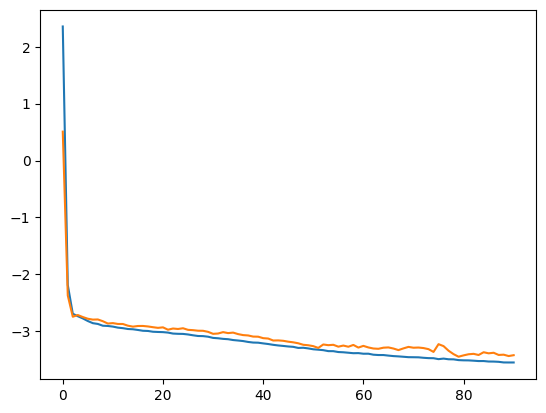

In [36]:
plt.plot(losses)
plt.show()

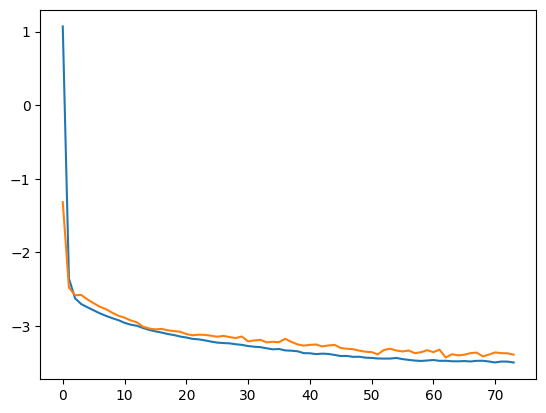

In [47]:
plt.plot(losses)
plt.show()

# load summaries

In [16]:
postfix = "_patchA_05_01_smoothleaky_nolog"
summary_file = np.load("/home/makinen/repositories/des-hybrid/summaries" + postfix + ".npz")

summaries_LFI = summary_file["summaries_lfi"]
params_Tru_LFI = summary_file["params_lfi"]
summaries_test = summary_file["summaries_test"]
params_Tru_test = summary_file["params_test"]

In [68]:
# np.savez("/home/makinen/repositories/des-hybrid/summaries" + postfix,
#          summaries_lfi=summaries_LFI,
#          params_lfi=params_Tru_LFI,
#          summaries_test=summaries_test,
#          params_test=params_Tru_test,
#          )

In [17]:
params_Tru_test

array([[0.4825825 , 0.5745539 , 0.7461434 ],
       [0.4825825 , 0.5745539 , 0.7461434 ],
       [0.4825825 , 0.5745539 , 0.7461434 ],
       ...,
       [0.5875606 , 0.37654847, 0.76118904],
       [0.5875606 , 0.37654847, 0.76118904],
       [0.5875606 , 0.37654847, 0.76118904]], dtype=float32)

In [18]:
params_Tru_LFI.shape

(3088, 3)

In [19]:
summaries_LFI[0, :]

array([ 0.41290778,  0.39613003,  0.4026416 ,  0.42905945,  0.38493636,
        0.393558  ,  0.40252423,  0.42823583,  0.31952116,  0.20417155,
        0.08990534,  0.07275945,  0.16829301,  0.08865322,  0.06903357,
        0.09854072,  0.3392441 ,  0.19668129,  0.05828516,  0.09369113,
        0.2051007 ,  0.0797905 ,  0.03167278,  0.04233271,  0.34324592,
        0.20634668,  0.07482523,  0.09417467,  0.19716741,  0.03671047,
        0.10941716,  0.06745777,  0.44208854,  0.40903655,  0.41349715,
        0.43884307,  0.4010907 ,  0.40305904,  0.41095924,  0.43859655,
        0.4025934 ,  0.26483104,  0.18509862,  0.11150114,  0.19077317,
        0.14887312,  0.07384863,  0.05746036,  0.41361225,  0.26388955,
        0.19899774,  0.1260594 ,  0.18924293,  0.09639249,  0.07730092,
        0.07795502,  0.48008615,  0.416374  ,  0.4144714 ,  0.43772495,
        0.39931118,  0.40059084,  0.40870336,  0.43583363,  0.45716417,
        0.31811386,  0.23793487,  0.1727727 ,  0.23217031,  0.10

In [20]:
summaries_LFI

array([[ 0.41290778,  0.39613003,  0.4026416 , ..., -0.2890625 ,
        -6.28125   , -1.8046875 ],
       [ 0.58371955,  0.52559936,  0.5304409 , ..., -0.45507812,
        -5.8125    , -1.640625  ],
       [ 0.41967416,  0.39516652,  0.4027531 , ..., -0.29882812,
        -6.40625   , -1.6875    ],
       ...,
       [ 0.41860172,  0.39765117,  0.40637466, ..., -0.36132812,
        -6.46875   , -1.7890625 ],
       [ 0.42122394,  0.40591896,  0.41452557, ..., -0.390625  ,
        -6.34375   , -1.7890625 ],
       [ 0.41795713,  0.4000979 ,  0.40904245, ..., -0.30078125,
        -6.34375   , -1.7578125 ]], dtype=float32)

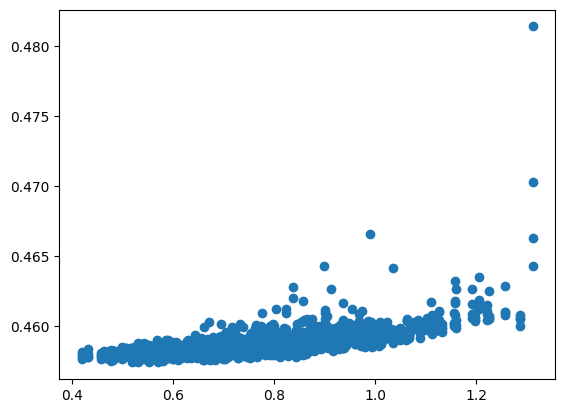

In [21]:
plt.scatter(params_Tru_LFI[:, 1], summaries_LFI[:, -4])
plt.show()
plt.close()

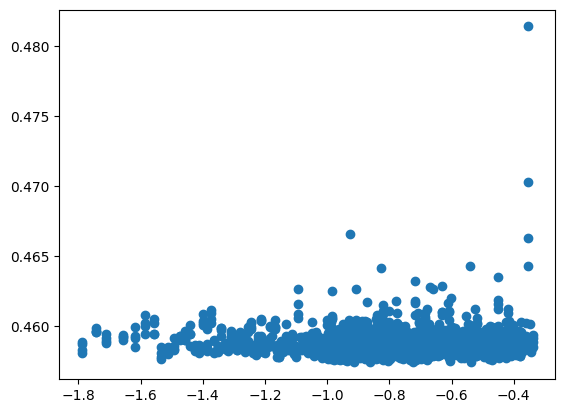

In [22]:
plt.scatter(params_Tru_LFI[:, 2], summaries_LFI[:, -4])
plt.show()
plt.close()

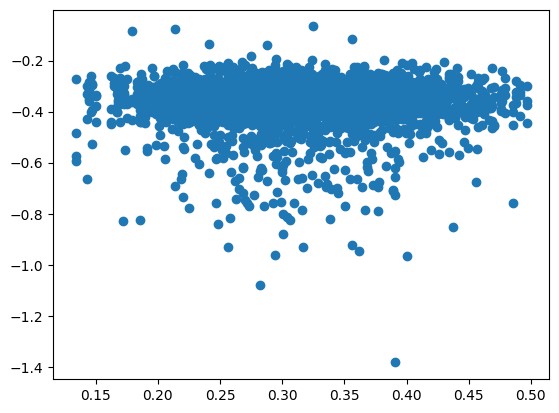

In [23]:
plt.scatter(params_Tru_LFI[:, 0], summaries_LFI[:, -3])
plt.show()
plt.close()

In [24]:
summaries_LFI[:, -2]

array([-6.28125, -5.8125 , -6.40625, ..., -6.46875, -6.34375, -6.34375],
      dtype=float32)

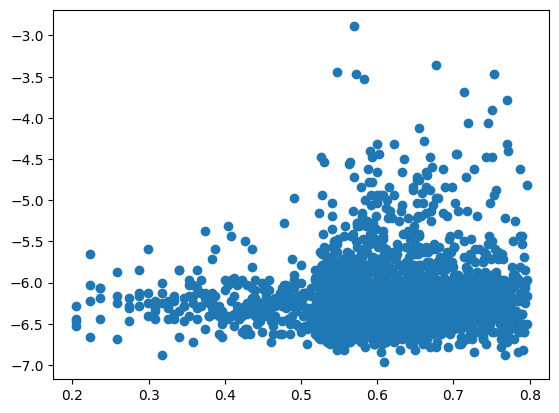

In [25]:
plt.scatter(params_Tru_test[:, 2], summaries_test[:, -2])
plt.show()
plt.close()

In [26]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch

import numpy as np
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [ ]:
# make a dataloader for the predicted thetas and true thetas
#loader = NumpyLoader(x=np.concatenate([np.array(summs), summs_cls], axis=-1), theta=np.array(data['theta']))

In [ ]:
for d in range(3):
    print(params_Tru_LFI[:, d].min() - 0.001, params_Tru_LFI[:, d].max() + 0.001)

In [148]:
theta_fid = np.array([0.3, 0.8, -1.0])
np.argmin(np.sum((params_Tru_LFI - theta_fid)**2, 1))

617

In [63]:
summaries_LFI.shape

(3024, 83)

In [27]:
def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

In [28]:
get_S8(params_Tru_LFI)[:, 1].max(), get_S8(params_Tru_LFI)[:, 1].min()

(0.9987983, 0.50127)

In [29]:
summaries_LFI.shape

(3088, 83)

In [30]:
from ili.embedding import FCN

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T


# CONVERT TO S8

params_Tru_LFI_S8 = get_S8(params_Tru_LFI)

loader = NumpyLoader(x=summaries_LFI,
                     theta=params_Tru_LFI_S8)

#n_hidden = [600, 300, 100, 4]
n_hidden = [100, 30, 10, 4] # [100, 50, 25, 4]
embedding_network = FCN(n_hidden = n_hidden, act_fn = "LeakyReLU") # ReLU


# define a prior for the scaled thetas
#low=[0.1339, 0.418, -1.789]; high=[0.5, 1.312, -0.338]

low=[0.15, 0.5, -1.0]; high=[0.52, 1.0, -0.3333] # in S8

prior = ili.utils.Uniform(low=low, high=high, device=device)

# instantiate your neural networks to be used as an ensemble

nets = [
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=7),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=10),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=110, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=110, num_transforms=10),

]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [31]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 5.


 Training neural network. Epochs trained: 71

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 2 / 5.


 Training neural network. Epochs trained: 49 72 epochs.

INFO:root:Training model 3 / 5.


 Training neural network. Epochs trained: 55 50 epochs.

INFO:root:Training model 4 / 5.


 Training neural network. Epochs trained: 55 56 epochs.

INFO:root:Training model 5 / 5.


 Training neural network. Epochs trained: 53 56 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 537.3359866142273 seconds to train models.


 Neural network successfully converged after 54 epochs.

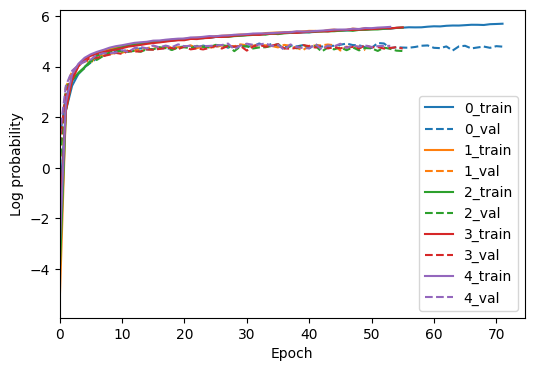

In [32]:
# FOR CNN + PK summaries

fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

In [216]:
params_Tru_LFI_S8.shape

(3024, 3)

In [53]:
# find somewhere close to fiducial

params_Tru_LFI_S8 = get_S8(params_Tru_LFI)

theta_fid = np.array([0.277, 0.811, -1.0])
target_index = np.argmin(np.sum(np.sqrt((params_Tru_LFI_S8 - theta_fid)**2), 1))

target_x = summaries_LFI[target_index]
target_theta = params_Tru_LFI_S8[target_index]

In [54]:
target_theta

array([ 0.2643356 ,  0.8117483 , -0.99779224], dtype=float32)

In [55]:
np.sum(np.sqrt((params_Tru_LFI_S8 - theta_fid)**2), 1)

array([0.22979177, 0.22979177, 0.22979177, ..., 0.73551851, 0.73551851,
       0.73551851])

Drawing 217 posterior samples:   0%|          | 0/217 [00:00<?, ?it/s]

Drawing 207 posterior samples:   0%|          | 0/207 [00:00<?, ?it/s]

Drawing 206 posterior samples:   0%|          | 0/206 [00:00<?, ?it/s]

Drawing 190 posterior samples:   0%|          | 0/190 [00:00<?, ?it/s]

Drawing 180 posterior samples:   0%|          | 0/180 [00:00<?, ?it/s]

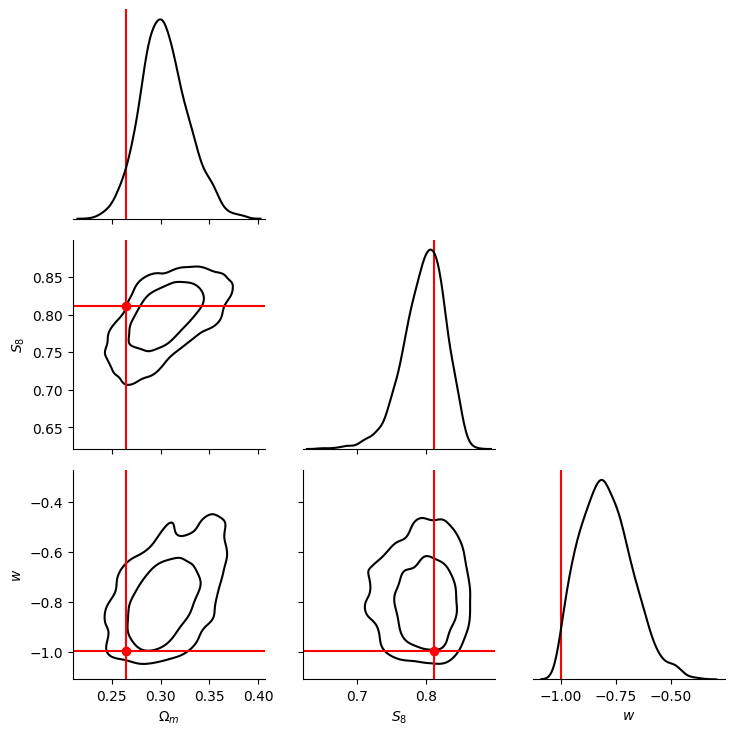

In [56]:

params = [r'$\Omega_m$', r'$S_8$', r'$w$']

metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=params
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = target_x, theta_fid=target_theta
)
plt.show()

In [197]:
summaries_LFI[..., :-3].shape

(3024, 80)

In [37]:
# do Cls-only

from ili.embedding import FCN

# DO JUST CLS NOW
loader_cls = NumpyLoader(x=summaries_LFI[..., :-3],
                     theta=params_Tru_LFI_S8)

n_hidden = [100, 30, 10, 4] # [100, 50, 25, 4]
embedding_network = FCN(n_hidden = n_hidden, act_fn = "LeakyReLU") # ReLU


# define a prior for the scaled thetas
#low=[0.1339, 0.418, -1.789]; high=[0.5, 1.312, -0.338]

low=[0.15, 0.5, -1.0]; high=[0.52, 1.0, -0.3333] # in S8

prior = ili.utils.Uniform(low=low, high=high, device=device)

# instantiate your neural networks to be used as an ensemble

nets = [
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=7),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=10),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=110, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=110, num_transforms=10),

]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner_cls = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [38]:
posterior_ensemble_cls, summaries_cls = runner_cls(loader=loader_cls)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 5.


 Training neural network. Epochs trained: 54

INFO:root:Training model 2 / 5.


 Training neural network. Epochs trained: 69 55 epochs.

INFO:root:Training model 3 / 5.


 Training neural network. Epochs trained: 71 70 epochs.

INFO:root:Training model 4 / 5.


 Training neural network. Epochs trained: 58 72 epochs.

INFO:root:Training model 5 / 5.


 Training neural network. Epochs trained: 48 59 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 500.306191444397 seconds to train models.


 Neural network successfully converged after 49 epochs.

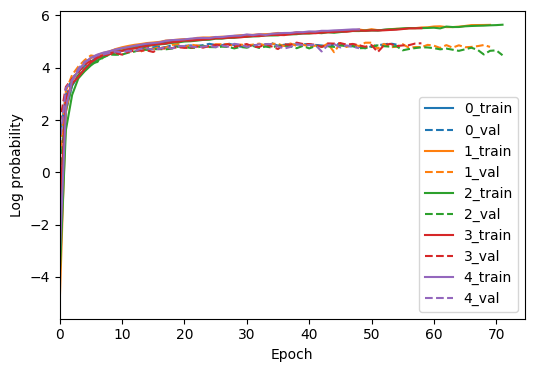

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries_cls):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

In [235]:
target_x.shape

(83,)

In [40]:
chains = posterior_ensemble.sample((100000,), x=torch.tensor(target_x).to(device))
chains_cls = posterior_ensemble_cls.sample((100000,), x=torch.tensor(target_x[:-3]).to(device))

Drawing 20557 posterior samples:   0%|          | 0/20557 [00:00<?, ?it/s]

Drawing 19732 posterior samples:   0%|          | 0/19732 [00:00<?, ?it/s]

Drawing 19623 posterior samples:   0%|          | 0/19623 [00:00<?, ?it/s]

Drawing 19851 posterior samples:   0%|          | 0/19851 [00:00<?, ?it/s]

Drawing 20237 posterior samples:   0%|          | 0/20237 [00:00<?, ?it/s]

Drawing 20398 posterior samples:   0%|          | 0/20398 [00:00<?, ?it/s]

Drawing 20679 posterior samples:   0%|          | 0/20679 [00:00<?, ?it/s]

Drawing 18575 posterior samples:   0%|          | 0/18575 [00:00<?, ?it/s]

Drawing 20713 posterior samples:   0%|          | 0/20713 [00:00<?, ?it/s]

Drawing 19635 posterior samples:   0%|          | 0/19635 [00:00<?, ?it/s]

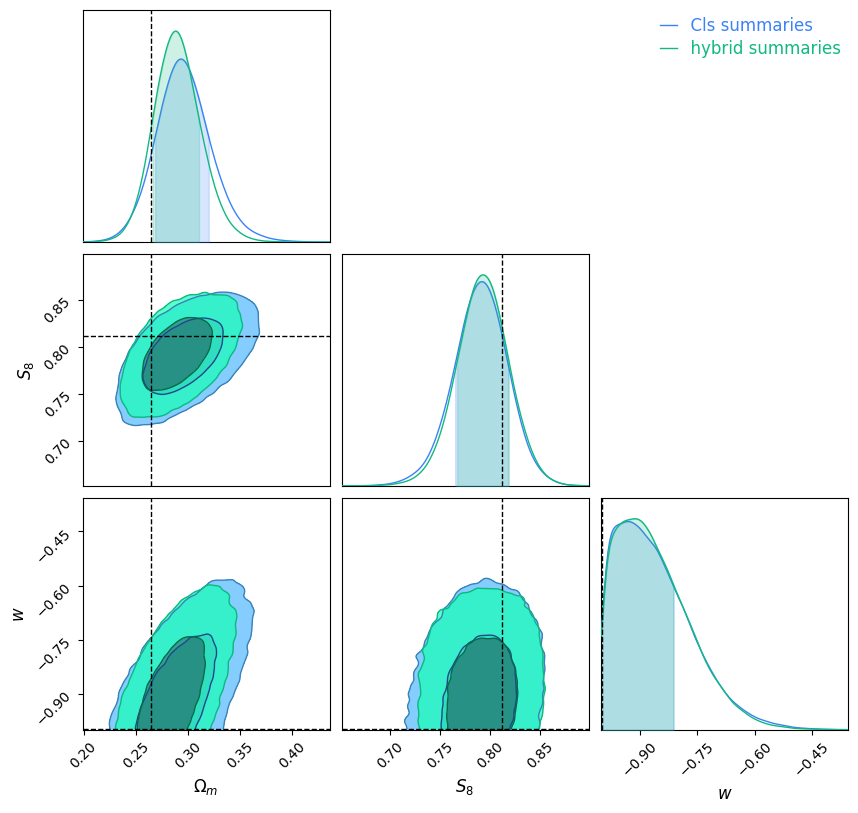

In [57]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
df_cls = pd.DataFrame((chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

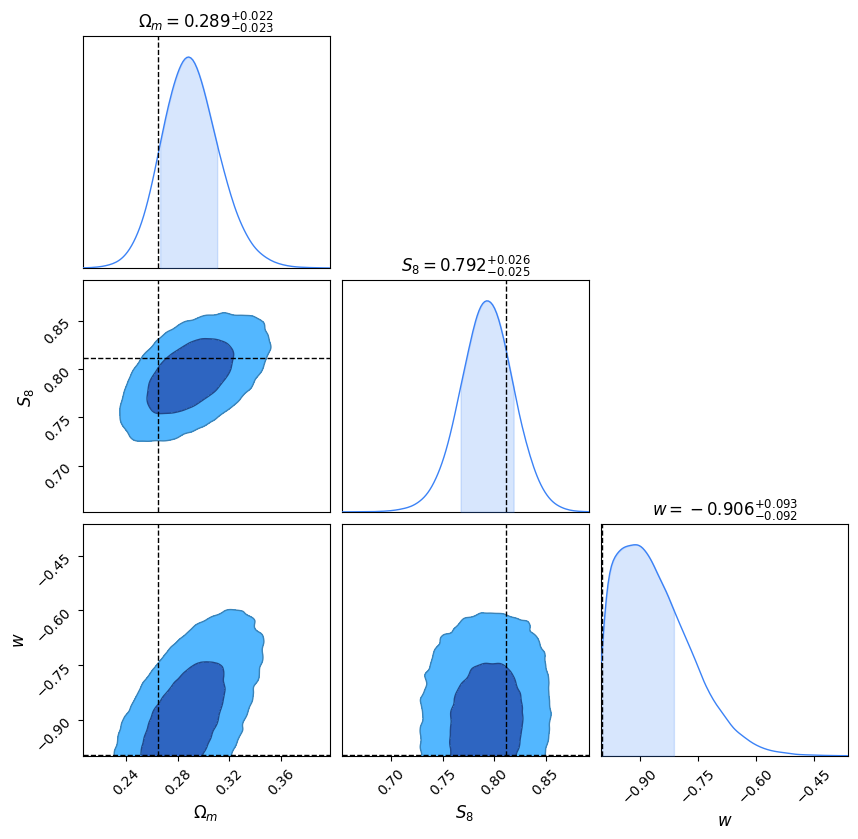

In [58]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
#df_cls = pd.DataFrame(get_S8(chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

#c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

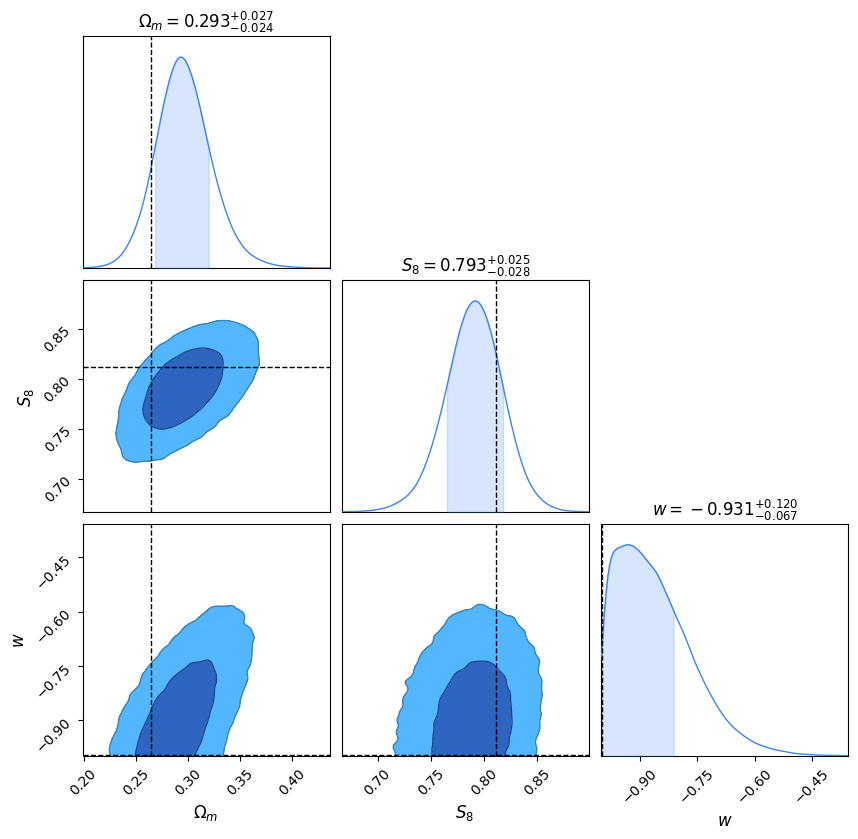

In [59]:
# LOOK AT CLS
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

#df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
df_cls = pd.DataFrame((chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
#c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

In [48]:
-.931 + 0.12

-0.811

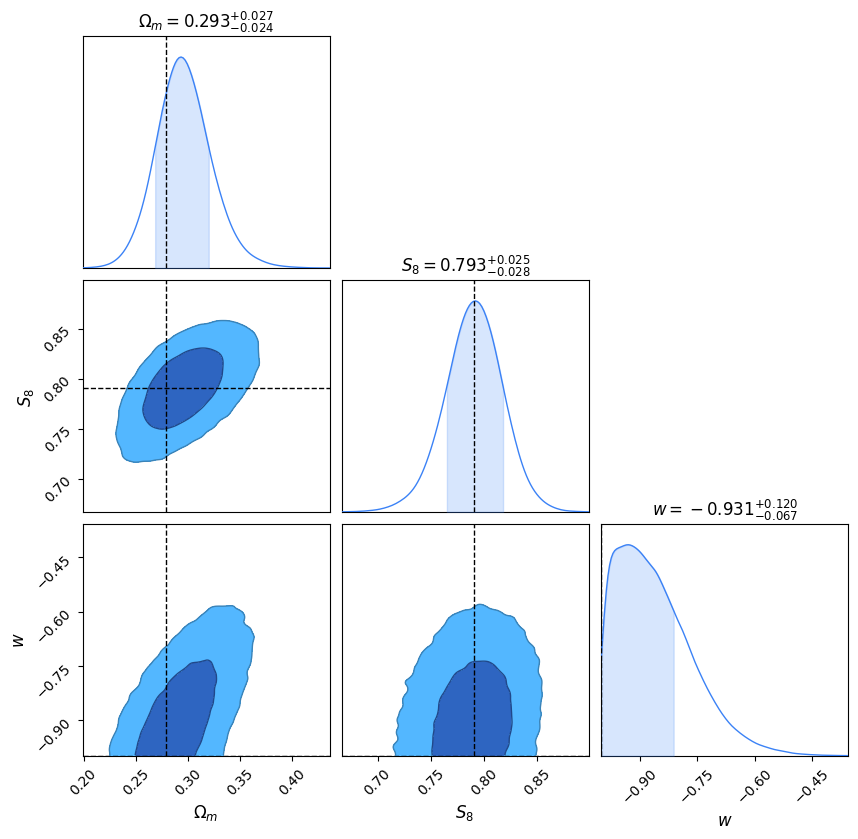

In [44]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame(chains.cpu().numpy(), columns=param_labels)
df_cls = pd.DataFrame(chains_cls.cpu().numpy(), columns=param_labels)


c = ChainConsumer()
#c.add_chain(Chain(samples = df_cls, name="Cls summaries"))

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
#c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: target_theta[0], param_labels[1]: target_theta[1], param_labels[2]:target_theta[2]}))


fig = c.plotter.plot()
plt.show()

In [45]:
postfix

'_patchA_05_01_smoothleaky_nolog'

In [46]:
np.savez("/home/makinen/repositories/des-hybrid/results_" + postfix,
         summaries_LFI=summaries_LFI,
         params_LFI=params_Tru_LFI_S8,
         summaries_test=summaries_test,
         params_test=get_S8(params_Tru_test),
         chains_hybrid=chains.cpu().numpy(),
         chains_cls=chains_cls.cpu().numpy()
        )

In [136]:
summaries_LFI

array([[ 0.4129078 ,  0.39613006,  0.4026416 , ..., -4.3125    ,
         5.875     , -1.9609375 ],
       [ 0.5837195 ,  0.52559936,  0.5304409 , ..., -3.6875    ,
         4.90625   , -1.6484375 ],
       [ 0.41967413,  0.39516655,  0.4027531 , ..., -4.4375    ,
         5.75      , -1.890625  ],
       ...,
       [ 0.41860172,  0.39765117,  0.40637466, ..., -4.21875   ,
         5.71875   , -1.8203125 ],
       [ 0.42122394,  0.40591896,  0.41452557, ..., -4.34375   ,
         5.8125    , -1.8984375 ],
       [ 0.41795707,  0.4000979 ,  0.40904242, ..., -4.1875    ,
         5.6875    , -1.8359375 ]], dtype=float32)

In [142]:
params_Tru_LFI_S8, summaries_LFI

(array([[ 0.26593444,  0.85225713, -0.8225309 ],
        [ 0.26593444,  0.85225713, -0.8225309 ],
        [ 0.26593444,  0.85225713, -0.8225309 ],
        ...,
        [ 0.3042592 ,  0.98120797, -0.46194866],
        [ 0.3042592 ,  0.98120797, -0.46194866],
        [ 0.3042592 ,  0.98120797, -0.46194866]], dtype=float32),
 array([[ 0.4129078 ,  0.39613006,  0.4026416 , ..., -4.3125    ,
          5.875     , -1.9609375 ],
        [ 0.5837195 ,  0.52559936,  0.5304409 , ..., -3.6875    ,
          4.90625   , -1.6484375 ],
        [ 0.41967413,  0.39516655,  0.4027531 , ..., -4.4375    ,
          5.75      , -1.890625  ],
        ...,
        [ 0.41860172,  0.39765117,  0.40637466, ..., -4.21875   ,
          5.71875   , -1.8203125 ],
        [ 0.42122394,  0.40591896,  0.41452557, ..., -4.34375   ,
          5.8125    , -1.8984375 ],
        [ 0.41795707,  0.4000979 ,  0.40904242, ..., -4.1875    ,
          5.6875    , -1.8359375 ]], dtype=float32))

In [146]:
# check coverage over TEST set

metric = PosteriorCoverage(
    num_samples=1000, sample_method='drect',
    labels=param_labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=(summaries_LFI), theta=(params_Tru_LFI_S8)
)
plt.show()

  0%|          | 0/3088 [00:00<?, ?it/s]


NotImplementedError: 

100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


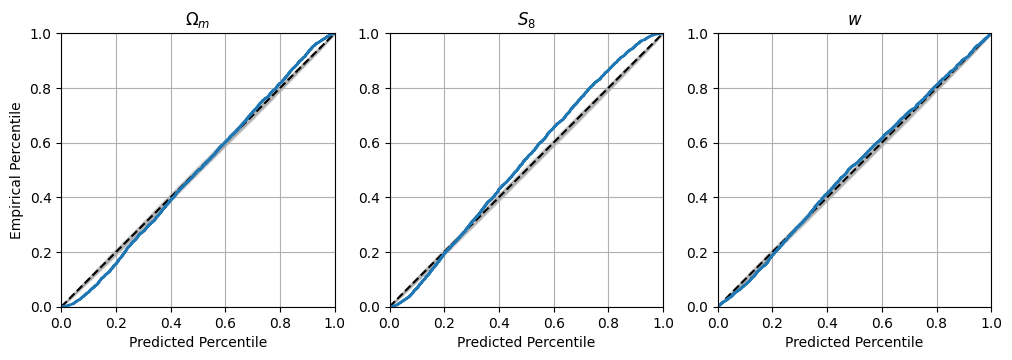

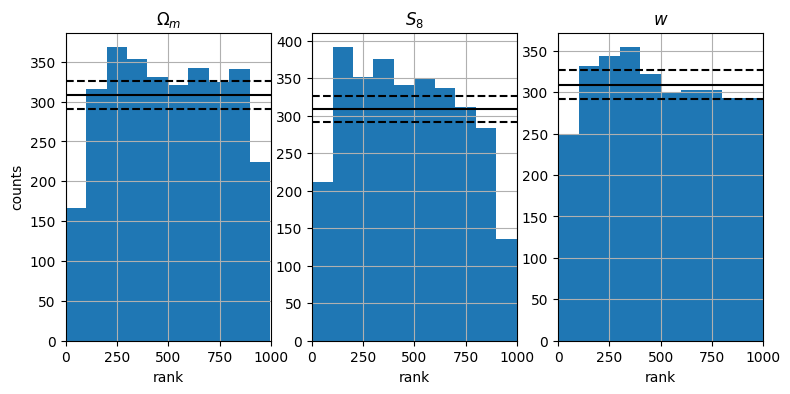

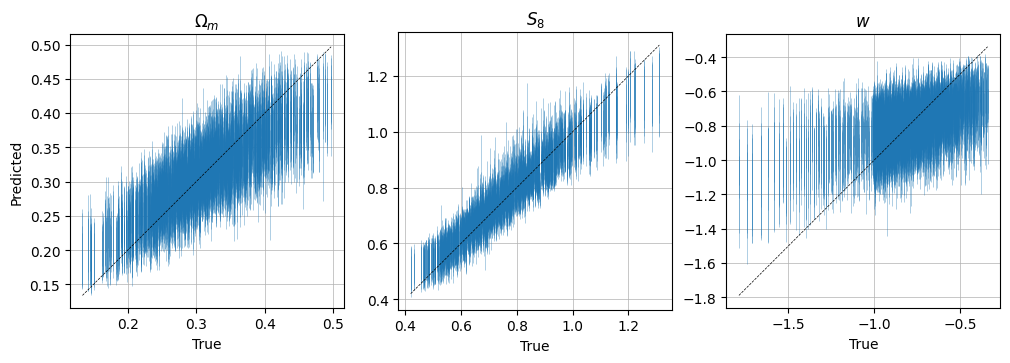

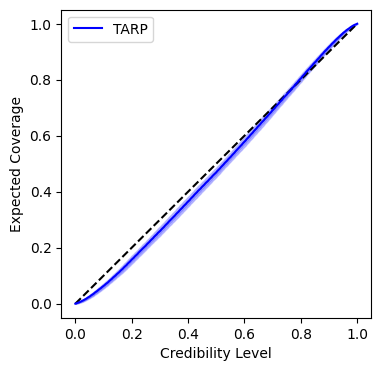

In [144]:
# check coverage

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=param_labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=summaries_test, theta=get_S8(params_Tru_test)
)
plt.show()

In [ ]:
# check parameter count

#sum(x.size for x in jax.tree_util.tree_leaves(wbest))